In [1]:
import os.path as path
import glob
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torchvision
import torchvision.models.detection as det
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torch.utils.data import random_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class PetDataset(Dataset):
    def __init__(self, root_dir, xforms, yforms):
        self.ann_dir = path.join(root_dir, "annotations", "trimaps")
        self.image_dir = path.join(root_dir, "images")
        self.image_files = glob.glob(path.join(self.image_dir, "*"))
        self.image_files = [x for x in self.image_files if path.splitext(x)[1] == ".jpg"]
        self.image_files = [x for x in self.image_files if Image.open(x).format == "JPEG"]
        self.image_files = [x for x in self.image_files if Image.open(x).mode == "RGB"]
        self.last_mrcnn_idx = 0
        self.breed_assoc = {x: self.last_mrcnn_idx + idx for 
                            idx, x in enumerate(sorted(list(set(
                                [ path.basename('_'.join(fname.split("_")[:-1])) for 
                                 fname in self.image_files]))))}
        self.xforms = xforms
        self.yforms = yforms
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        imf = self.image_files[idx]
        bname = path.basename(path.splitext(imf)[0])
        ann = path.join(self.ann_dir, bname) + '.png'

        # image
        image = self.xforms(Image.open(imf)).to(device)

        # mask
        mask = self.yforms(Image.open(ann)).to(device)
        unnormed_mask = (mask * 300).floor()
        unnormed_boundary = (unnormed_mask == 3.0).to(torch.float)
        unnormed_interior = (unnormed_mask == 1.0 ).to(torch.float)
        unnormed_exterior = (unnormed_mask == 2.0 ).to(torch.float)
        mask = unnormed_boundary + unnormed_interior

        # label
        category = path.basename('_'.join(imf.split("_")[:-1]))
        labels = torch.tensor([self.breed_assoc[category]]).to(torch.int64).to(device)
        
        # box
        indices = torch.nonzero(mask)
        
        if indices.numel() == 0:
            left_x = 0
            bottom_y = 0
            right_x = 224
            top_y = 224

        else:
            left_x = indices[:,0].min()
            right_x = indices[:,0].max()
            bottom_y = indices[:,1].min()
            top_y = indices[:,1].max()
            
        boxes = torch.tensor([left_x,bottom_y,right_x,top_y]).unsqueeze(0).to(device)
        
        
        return image, {"boxes": boxes, "labels": labels, "masks": mask}

In [12]:
transformx = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
def unnormalize(tensor):
    for t, m, s in zip(tensor,[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    return tensor

transformy = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
ds = PetDataset(".", transformx, transformy)
split_ratio = [0.8, 0.2]

# Split the dataset
train_dataset, test_dataset = random_split(ds, split_ratio, generator=torch.Generator().manual_seed(42))

def custom_collate(batch):
    imgs = [b[0] for b in batch]
    targets = [b[1] for b in batch]  # Keep targets as a list of dicts
    return torch.stack(imgs, dim=0), targets

bs = 1
dl = DataLoader(train_dataset, shuffle=True, collate_fn=custom_collate, batch_size=bs)
tl = DataLoader(test_dataset, collate_fn=custom_collate,batch_size=bs)

to_pil = transforms.ToPILImage()

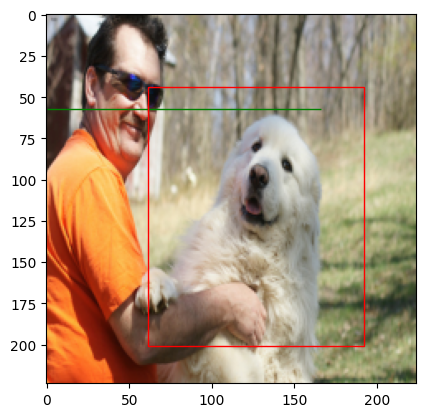

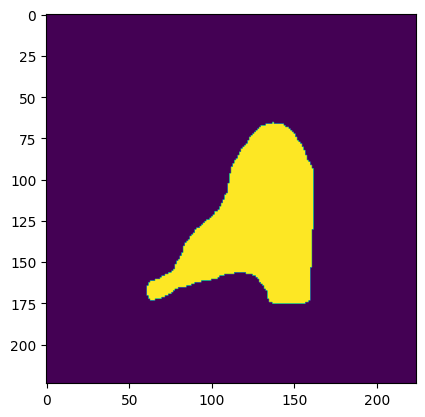

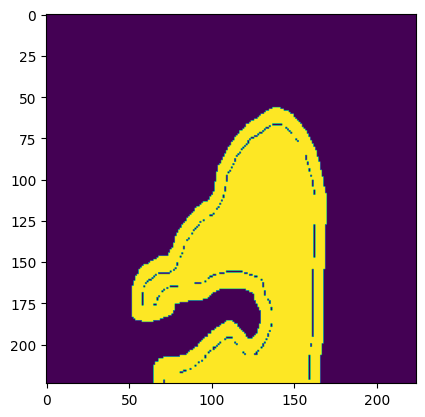

In [13]:
model = torch.load("checkpoint_8").to(device)

tdata, tlabel = test_dataset[100]
model.eval()
with torch.no_grad():
    preds = model([tdata])

tim = to_pil(unnormalize(tdata))

plt.imshow(tim)
pbox = preds[0]['boxes'][0]
lbox = tlabel['boxes'][0]
for box in preds[0]['boxes']:
    plt.gca().add_patch(plt.Rectangle((int(lbox[0]), int(lbox[1])), int(lbox[3] - lbox[1]), int(lbox[2] - lbox[0] ), linewidth=1, edgecolor='g', facecolor='none'))
    plt.gca().add_patch(plt.Rectangle((int(pbox[0]), int(pbox[1])), int(pbox[3] - pbox[1]), int(pbox[2] - pbox[0] ), linewidth=1, edgecolor='r', facecolor='none'))
    break
plt.show()

for mask in preds[0]["masks"]:
    plt.imshow(to_pil((mask>0.5).to(torch.uint8)))
    plt.show()
    break

plt.imshow(to_pil((tlabel['masks'].squeeze() >0.5).to(torch.uint8)))
plt.show()

In [14]:
indices = torch.nonzero(tlabel["masks"].squeeze())

In [15]:

left_x = indices[:,0].min()
right_x = indices[:,0].max()
bottom_y = indices[:,1].min()
top_y = indices[:,1].max()

torch.tensor([left_x,bottom_y,right_x,top_y]).unsqueeze(0).to(device)

tensor([[ 57,  52, 223, 169]], device='cuda:0')

tensor([  0,  57,   0, 223], device='cuda:0')